In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anim

import crocosi.postp as pp
from crocosi.jet import set_relevant_time

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


---

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28*2)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [7]:
client

Client Scheduler: tcp://10.148.1.31:34822 Dashboard: http://10.148.1.31:8787/status,Cluster Workers: 46 Cores: 46 Memory: 197.34 GB


---

In [8]:
#root_path = '/Users/zcaspar/'
root_path = '/home/datawork-lops-osi/slgentil/croco/jetn/'
run = 'jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/'

gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.CROCOrun(root_path+run, prefix='file_', open_nc=['surf'], 
                chunk_time={'his': 1, 'surf': 1}, grid_params=gparams)
#set_relevant_time(r) # this triggers slow computations later on, don't know why

In [9]:
#path_data='/Users/zcaspar/jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/'
#df = dd.read_csv(glob(root_path+run+'t?/float.????'), 
df = dd.read_csv(glob(root_path+run+'t1/float.????'), 
                 names=['id','time','xgrid','ygrid','zgrid','depth','temp','X1','X2','X3','X4','X5'],
                 delim_whitespace=True).persist()
df.head()

,id,time,xgrid,ygrid,zgrid,depth,temp,X1,X2,X3,X4,X5
0,7161,1500.0069,196.40944,541.79652,50.0,-0.935944,25.886666,0.058079,-0.105506,-5.820925e-08,3.420817e-07,-8.260263
1,7162,1500.0069,196.40937,543.30184,50.0,-0.940022,25.885229,0.057283,-0.101750,-2.034746e-08,3.515808e-07,-8.300321
2,7163,1500.0069,196.40946,544.80716,50.0,-0.944117,25.884374,0.058512,-0.097537,-1.201106e-09,3.599363e-07,-8.340519
3,7164,1500.0069,196.40961,546.31250,50.0,-0.948345,25.884627,0.060480,-0.093268,-1.958836e-08,3.627984e-07,-8.381996
4,7165,1500.0069,196.40971,547.81780,50.0,-0.952706,25.885603,0.061626,-0.089432,-6.096121e-08,3.575484e-07,-8.424740


In [18]:
# sort right away data by time:
#df = df.apply(lambda d: d.sort_values('time')).persist()
# not working, not implemented in dask (too much shufling)

In [19]:
# note for AP for future stuff
#df.groupby(['id']).get_group(2).compute()
#df.groupby(['id']).apply(lambda d: d.sort_values('time'), meta=df).to_delayed()
# with stack to get dask array

### paramètres :

In [10]:
#Dt = 6*6 # Dt = X*6 images toutes les Xh
dt = 2 # temps avant l'instant t plotté utilisé pour visualiser la trajectoire (en jours)
#ti = 1500 # temps0 en jours
#tf = 1599 # temps d'arrêt en jours
vari = 'ssh' # variable affichée en fond pour une seule variable
#vari1 = 'u'  # 1ère variable affichée en fond pour 2 variables
#vari2 = 'v'  # 2ème variable affichée en fond pour 2 variables
#floats_var = 'depth' # variable affichée le long de la trajectoire du drifter
#float_id = [102,300] # numéro des flotteurs voulu
time0 = 1550
time1 = 1565

In [96]:
figdir = '/home1/datahome/zcaspar/figs/'
print('Figures directory: '+figdir)

def genfig(i, ds, v, flt, n, size, overwrite=True, offline=True):
    
    figname = figdir+'float_%s_%s_t%05d' %(v, size, n)+'.png'
    
    if not os.path.isfile(figname) or overwrite:
        time = ds['time_instant'].values
        
        #
        MPL_LOCK = threading.Lock()
        with MPL_LOCK:
            plt.switch_backend('agg')    
            #
            flti = flt.loc[i]
            fig = plt.figure(figsize=(10,10))
            grid = plt.GridSpec(3, 1, wspace=0.4, hspace=0.3)
            if size=='zoom':
                ax = plt.subplot(grid[2, :])
    #off1 = .5
                ax.plot(flt.index,flt.X1)
                ax.axvline(x=i, color='k', lw=1)
                ax.set_xlabel('Time (days)');ax.set_ylabel(r'Zonal velocity ($m.s^{-1}$)')
                ax = plt.subplot(grid[:2, :])    
                ax.plot(flt.xgrid, flt.ygrid,'k')
   
                ax.plot(flti.xgrid, flti.ygrid, marker='o', ms=8, 
                         markeredgecolor='k',markerfacecolor='r')
            
                ds.plot.contourf(ax=ax, levels = np.linspace(-1,0,20), cmap='RdBu_r')
            if size == 'large':
                ax = plt.subplot(1,1,1)
                ax.plot(flt.xgrid, flt.ygrid,'k')
   
                ax.plot(flti.xgrid, flti.ygrid, marker='o', ms=8, 
                         markeredgecolor='k',markerfacecolor='r')
                ds.plot(ax=ax, cmap='RdBu_r')
                ax.set_aspect('equal')
            ax.set_xlabel(r'$x_\rho$');ax.set_ylabel(r'$y_\rho$')
            ax.set_title(r'Time$\simeq$%sdays'%np.around(i,decimals=1))
            #print(figname)
            if offline:
                fig.savefig(figname)
                plt.close()
            #
        m = 1.
    else:
        m = -1.
    return m

Figures directory: /home1/datahome/zcaspar/figs/


In [ ]:
#Décale les données du fichier surf sur les mêmes temps que les données des floats ( décalage de 5min sinon):
v1 = (r['surf']['u'].shift(time=-1)+r['surf']['u'])*.5
v2 = (r['surf']['v'].shift(time=-1)+r['surf']['v'])*.5
v0 = (r['surf']['ssh'].shift(time=-1)+r['surf']['ssh'])*.5

In [17]:
ds = v0#r['surf'][vari]
ds = ds.assign_coords(time=ds.time_counter,x_rho = ds.x_rho,y_rho = ds.y_rho)

In [18]:
ds

<xarray.DataArray 'ssh' (time: 72000, y_rho: 722, x_rho: 258)>
dask.array<concatenate, shape=(72000, 722, 258), dtype=float32, chunksize=(1, 722, 258), chunktype=numpy.ndarray>
Coordinates:
    xi_rho        (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    eta_rho       (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    time_instant  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_counter  (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 2e+03 2e+03 2e+03
    f             (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
  * time          (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 2e+03 2e+03 2e+03
  * x_rho         (x_rho) int64 0 1 2 3 4 5 6 7 ... 251 252 253 254 255 256 257
  * y_rho         (y_rho) int64 0 1 2 3 4 5 6 7 ... 715 716 717 718 719 720 721
Attributes:
    long_name:           free-surface
    units:               meter
    online_operation:    instant
    interval_operation:  300

In [81]:
flt = df.groupby('id').get_group(225).compute().sort_values('time').set_index('time')

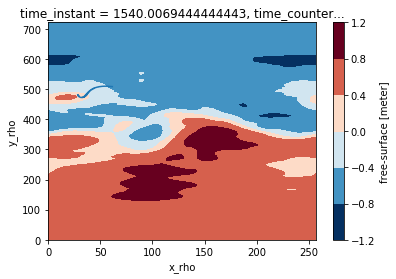

In [82]:
ds.sel(time=1540,method='nearest').plot.contourf()
plt.plot(flt.xgrid.loc[1550:1570],flt.ygrid.loc[1550:1570])

In [93]:
rg = range(6*24*50,6*24*70) # 3 days
II = np.array_split(rg,len(rg)/56) # 4 maybe will work
print('%d loops to be done'%len(II))

51 loops to be done


In [94]:
fltI= flt.loc[time0:time1]
dsi = ds.sel(x_rho=slice(int(fltI.xgrid.min())-1,
                                int(fltI.xgrid.max())+1)
                   ,y_rho=slice(int(fltI.ygrid.min()-1)
                                ,int(fltI.ygrid.max())+1))

1.0

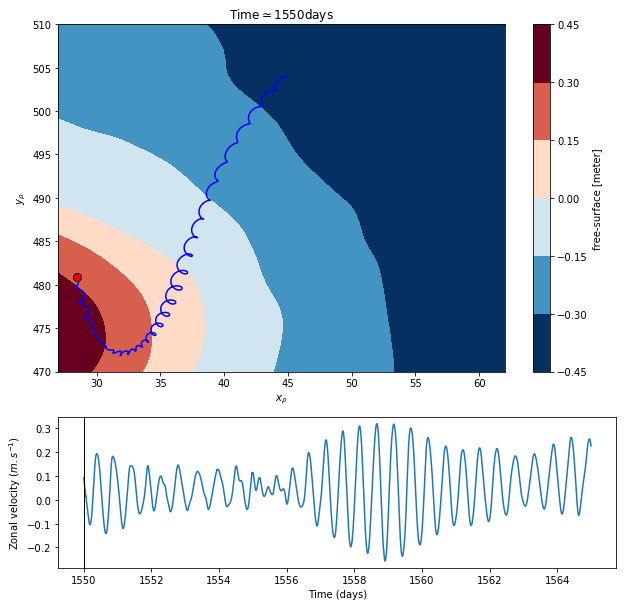

In [97]:
genfig(1550, dsi.sel(time=1540,method='nearest'), 'ssh', \
                              flt.loc[1550:1565], 0, \
                              overwrite=True, offline=False)

  7200 - 7256
  7257 - 7313
  7314 - 7370
  7371 - 7427
  7428 - 7484
  7485 - 7541
  7542 - 7598
  7599 - 7655
  7656 - 7712
  7713 - 7769
  7770 - 7826
  7827 - 7883
  7884 - 7940
  7941 - 7997
  7998 - 8054
  8055 - 8111
  8112 - 8168
  8169 - 8225
  8226 - 8282
  8283 - 8339
  8340 - 8396
  8397 - 8453
  8454 - 8510
  8511 - 8567
  8568 - 8623
  8624 - 8679
  8680 - 8735
  8736 - 8791
  8792 - 8847
  8848 - 8903
  8904 - 8959
  8960 - 9015
  9016 - 9071
  9072 - 9127
  9128 - 9183
  9184 - 9239
  9240 - 9295
  9296 - 9351
  9352 - 9407
  9408 - 9463
  9464 - 9519
  9520 - 9575


KeyboardInterrupt: 

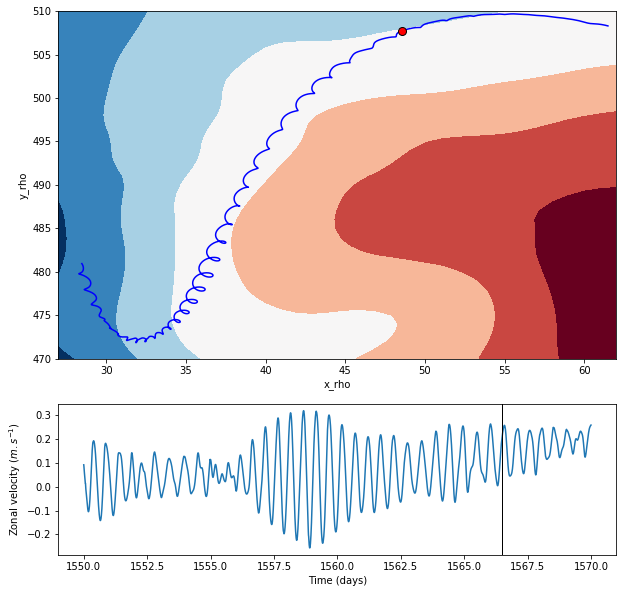

In [98]:
n = 0
for I in II:
    print('  %d - %d'%(I[0],I[-1]))
    #print(ds.time.isel(time=i))
    #lt = ds.time_instant.isel(time=I).values
    #ldf = df[ (df.time>lt[0]-2) & (df.time<lt[-1]) ]
    values = [genfig(i, dsi.sel(time=i,method='nearest'), 'ssh', \
                              flt.loc[time0:time1], j+n, \
                              'zoom', overwrite=True, offline=True) for j,i in enumerate(flt.index[I])]
    values1 = [genfig(i, ds.sel(time=i,method='nearest'), 'ssh', \
                              flt1.loc[time0:time1], j+n, \
                              'large', overwrite=True, offline=True) for i in flt1.index[I]]
    n += len(I)

In [99]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py", line 662, in log_errors
    yield
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/client.py", line 1290, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py", line 662, in log_errors
    yield
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/client.py", line 1019, in _reconnect
    await self._close()
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/client.py", l

In [30]:
ds = r['surf'][vari]
ds = ds.assign_coords(time = ds.time_counter,x_rho = ds.x_rho,y_rho = ds.y_rho)

In [31]:
ds

<xarray.DataArray 'ssh' (time: 72000, y_rho: 722, x_rho: 258)>
dask.array<concatenate, shape=(72000, 722, 258), dtype=float32, chunksize=(1, 722, 258), chunktype=numpy.ndarray>
Coordinates:
    eta_rho       (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    xi_rho        (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    time_instant  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_counter  (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 2e+03 2e+03 2e+03
    f             (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
  * time          (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 2e+03 2e+03 2e+03
  * x_rho         (x_rho) int64 0 1 2 3 4 5 6 7 ... 251 252 253 254 255 256 257
  * y_rho         (y_rho) int64 0 1 2 3 4 5 6 7 ... 715 716 717 718 719 720 721
Attributes:
    long_name:           free-surface
    units:               meter
    online_operation:    instant
    interval_operation:  300

In [ ]:
plt.ioff()

for I in I1:
    print('  %d - %d'%(I[0],I[-1]))
    #print(flt1.loc[1540:1540.5]i)
    values = [genfig(flt.loc[1540:1545], ds, i,
                              'ssh',offline=False, print_fig=False) for i in flt.index[I]]
   # futures = client.compute(values)
   # results = client.gather(futures)


  5760 - 5819


In [ ]:
cluster.close()

In [15]:
# could delete all figures beforehand
figdir = '/home1/scratch/zcaspar/figs/'
print('Figures directory: '+figdir)

def genfig(i, ds, v, df, overwrite=True):
    
    figname = figdir+'float_%s_t%05d' %(v, i)+'.png'
    
    if not os.path.isfile(figname) or overwrite:
        time = ds['time_instant'].values
        ldf = df[ (df.time>=time-dt) & (df.time<=time) ]
        #
        MPL_LOCK = threading.Lock()
        with MPL_LOCK:
            plt.switch_backend('agg')    
            #
            fig = plt.figure(figsize=(12,12))
            ax = fig.add_subplot(1,2,1)        
            ds[v].plot(ax=ax)
            ax.plot(ldf.xgrid, ldf.ygrid, '.', color='k')
            fig.savefig(figname)
            #
            m = 1.
    else:
        m = -1.
    return m

Figures directory: /home1/scratch/aponte/figs/


In [16]:
ds = r['surf'][vari].to_dataset()
#v = (r['surf'][vari].shift(time=-1)+r['surf'][vari])*.5
#t = ds.time

In [17]:
ds

<xarray.Dataset>
Dimensions:       (time: 72000, x_rho: 258, y_rho: 722)
Coordinates:
    eta_rho       (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    xi_rho        (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    time_instant  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_counter  (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 2e+03 2e+03 2e+03
    f             (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
Dimensions without coordinates: time, x_rho, y_rho
Data variables:
    ssh           (time, y_rho, x_rho) float32 dask.array<chunksize=(1, 722, 258), meta=np.ndarray>

In [23]:
rg = range(0,6*24*3) # 3 days
II = np.array_split(rg,len(rg)/56) # 4 maybe will work
print('%d loops to be done'%len(II))
for I in II:
    print('  %d - %d'%(I[0],I[-1]))
    lt = ds.time_instant.isel(time=I).values
    ldf = df[ (df.time>lt[0]-dt) & (df.time<lt[-1]) ]
    values = [delayed(genfig)(i, ds.isel(time=i), vari, \
                              ldf, \
                              overwrite=True) for i in I]
    futures = client.compute(values)
    results = client.gather(futures)

7 loops to be done
  0 - 61


PermissionError: [Errno 13] Permission denied: '/home1/scratch/aponte/figs/float_ssh_t00004.png'

In [ ]:
cluster.close()

1.0

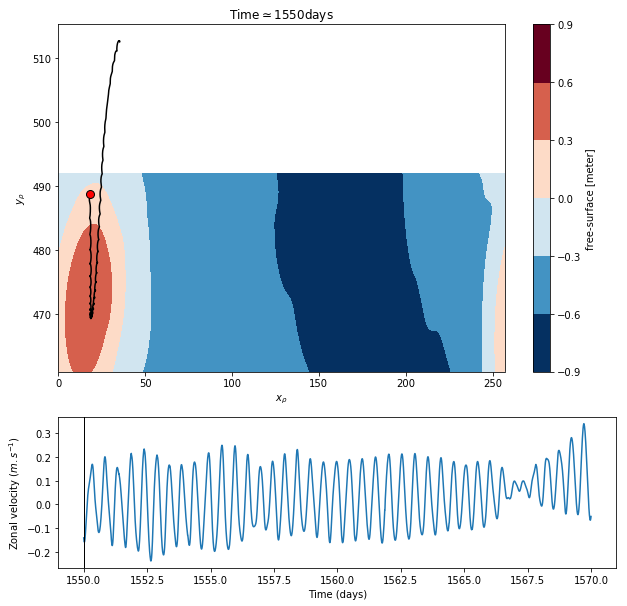